In [18]:
from torch import nn
from tqdm import tqdm_notebook as tqdm
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact
import pdb
import pickle
import time

import matplotlib.pyplot as plt
import seaborn.apionly as sns

plt.style.use('clean')

%run utils.py

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
w = widgets.IntText()

In [3]:
@interact(x=w)
def f(x):
    WINDOW_SIZE = 100
    
    epoch_progress = len(losses[-1])
    i = max(epoch_progress-WINDOW_SIZE,0)
    if len(losses) > 1:
        diffs = np.array(losses[-1][i:epoch_progress]) - np.array(losses[-2][i:epoch_progress])
        plt.plot(range(i,epoch_progress), diffs, label='This-Last Epoch')
    else:
        plt.plot(range(i,epoch_progress), losses[-1][i:epoch_progress], label='This Epoch')
    plt.xlim((i,epoch_progress))
    plt.legend()
    plt.show()

interactive(children=(IntText(value=0, description='x'), Output()), _dom_classes=('widget-interact',))

In [4]:
def df_to_torch(df_clean):
    y = Variable(torch.from_numpy(df_clean['duration'].as_matrix()).float())
    x = Variable(torch.from_numpy(df_clean.drop(['duration',], axis=1).as_matrix()).float())
    return x, y

In [5]:
D_in, H, D_out = 36, 50, 1
model = nn.Sequential(
    nn.Linear(D_in, H, bias=False),
    nn.Tanh(),
    nn.Linear(H, D_out, bias=False),
)

loss_fn = torch.nn.MSELoss(size_average=False)

In [6]:
losses = []

In [7]:
i = 0
num_entries = 13484192
chunksize = 10000
w.value = 0
learning_rate = 1e-7
display_freq = 10

num_epochs = 30
with tqdm(total=num_epochs*num_entries) as pbar:
    for epoch in range(num_epochs):
        losses.append([])
        df_iter = pd.read_csv('data/yellow_tripdata_2009-01_train.csv', chunksize=chunksize)
        total_loss = 0
        for df in df_iter:
            
            df = df.loc[(df['duration'] < 3600 * 2) & (df['duration'] > 120),:]
            x, y = df_to_torch(df)
            pbar.update(1)
            # Forward pass: compute predicted y by passing x to the model. Module objects
            # override the _call_ operator so you can call them like functions. When
            # doing so you pass a Variable of input data to the Module and it produces
            # a Variable of output data.
            y_pred = model(x)

            # Compute and print loss. We pass Variables containing the predicted and true
            # values of y, and the loss function returns a Variable containing the loss.
            loss = loss_fn(y_pred, y)
            total_loss += loss.data[0]
            
            # dashboard logic
            losses[-1].append(loss.data[0]/chunksize)
            i += 1
            if (i % display_freq == 0):
                w.value = w.value + 1
            
            # Zero the gradients before running the backward pass.
            model.zero_grad()

            # Backward pass: compute gradient of the loss with respect to all the learnable
            # parameters of the model. Internally, the parameters of each Module are stored
            # in Variables with requires_grad=True, so this call will compute gradients for
            # all learnable parameters in the model.
            loss.backward()

            # Update the weights using gradient descent. Each parameter is a Variable, so
            # we can access its data and gradients like we did before.
            for param in model.parameters():
                param.data -= learning_rate * param.grad.data
                
        print('epoch', epoch, 'loss', total_loss/num_entries)

HBox(children=(IntProgress(value=0, max=404525760), HTML(value='')))

epoch 0 loss 55256.13952797469
epoch 1 loss 43497.16038469342
epoch 2 loss 42561.275177036936
epoch 3 loss 42100.353360142006
epoch 4 loss 41861.67541369924
epoch 5 loss 41711.43039938915
epoch 6 loss 41587.58053296779
epoch 7 loss 41456.355246943975
epoch 8 loss 41348.80136726027
epoch 9 loss 41279.321745492794
epoch 10 loss 41219.634572987394
epoch 11 loss 41187.15896718172
epoch 12 loss 41145.81866633166



KeyboardInterrupt: 

In [8]:
model.save_state_dict('results/FR_nn_weights.pt')

AttributeError: 'Sequential' object has no attribute 'save_state_dict'

In [19]:
d = model.state_dict()
pickle.dump(d, open('results/FR_nn_weights.pt', 'wb'))

In [43]:
test_df = pd.read_csv('data/yellow_tripdata_2009-01_test.csv')
test_df = test_df.loc[(test_df['duration'] < 3600 * 2) & (test_df['duration'] > 120),:]

In [46]:
1 - np.std(60*errs)**2 / test_df.duration.std()**2

0.6797969394014256

In [29]:
errs = []
test_iter = pd.read_csv('data/yellow_tripdata_2009-01_test.csv', chunksize=100000)
for df in tqdm(test_iter):
    df = df.loc[(df['duration'] < 3600 * 2) & (df['duration'] > 120),:]
    x, y = df_to_torch(df)
    errs += list((y - model(x).squeeze()).data.numpy()/60)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [47]:
df.columns

Index(['duration', 'Trip_Distance', 'Start_Lon', 'Start_Lat', 'End_Lon',
       'End_Lat', 'week_0', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5',
       'week_6', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23'],
      dtype='object')

In [51]:
def get_filtered_errs(day, hour):
    errs = []
    test_iter = pd.read_csv('data/yellow_tripdata_2009-01_test.csv', chunksize=100000)
    for df in tqdm(test_iter):
        df = df.loc[(df['duration'] < 3600 * 2) & (df['duration'] > 120) &
                    (df['week_{}'.format(day)] == 1) & (df['hour_{}'.format(hour)] == 1),:]
        x, y = df_to_torch(df)
        errs += list((y - model(x).squeeze()).data.numpy()/60)
    return np.array(errs)

In [53]:
tues0errs = get_filtered_errs(1, 0)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [64]:
model.state_dict()

OrderedDict([('0.weight', 
               -6.7131  -5.3898  -5.2211  ...   -0.5684  -0.5240  -0.3523
               -0.1239   0.3352   0.5233  ...   -1.8631  -1.8280  -2.0494
               -0.7041   0.1179  -0.0568  ...   -5.5683  -5.8238  -5.9347
                         ...               ⋱              ...            
                3.4464  -1.7407  -1.9854  ...    3.1583   3.4001   3.0320
               -0.4470   0.0892   0.1278  ...   -0.6920   0.5706  -1.6982
               -6.6336   3.4225   1.5398  ...    0.7933   1.2883   1.3808
              [torch.FloatTensor of size 50x36]), ('2.weight', 
              
              Columns 0 to 7 
              -38.7345 -45.9827  50.5846  57.9655 -38.2473  35.0266 -42.3580 -39.7950
              
              Columns 8 to 15 
              -46.4611  43.8492  48.7893 -60.1340 -49.5148  46.4025 -70.2076 -46.0062
              
              Columns 16 to 23 
               48.1139 -34.1263  45.4359 -46.3013  35.8642 -53.1262  85.7021  41.

In [55]:
np.std(tues0errs)

3.7181666

In [30]:
errs = np.array(errs)

In [31]:
np.mean(errs)

-0.073984928

In [60]:
np.std(np.abs(errs))

3.0173934

In [59]:
test_df.duration.std() / 60

6.853783251669408

In [39]:
np.

3.8783154

In [62]:
np.percentile(np.abs(errs), 99)

12.790218696594224

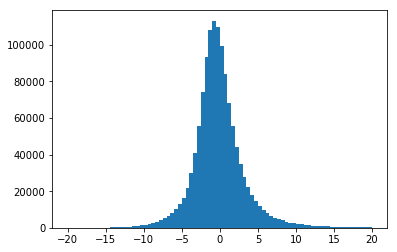

In [38]:
plt.hist(errs, bins=np.arange(-20,20.1,.5));

In [40]:
df.head()

,duration,Trip_Distance,Start_Lon,Start_Lat,End_Lon,End_Lat,week_0,week_1,week_2,week_3,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
1300000,306.0,-0.684758,0.549058,0.956021,0.304054,0.462084,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1300001,864.0,1.459473,1.020434,0.971887,-0.520599,-1.129734,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1300002,192.0,-0.593514,-0.508017,0.162640,-0.113236,0.457010,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1300003,136.0,-0.776002,-0.268128,0.706322,-0.388813,0.360499,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1300004,376.0,-0.411026,-0.123961,1.337730,0.258689,1.802127,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


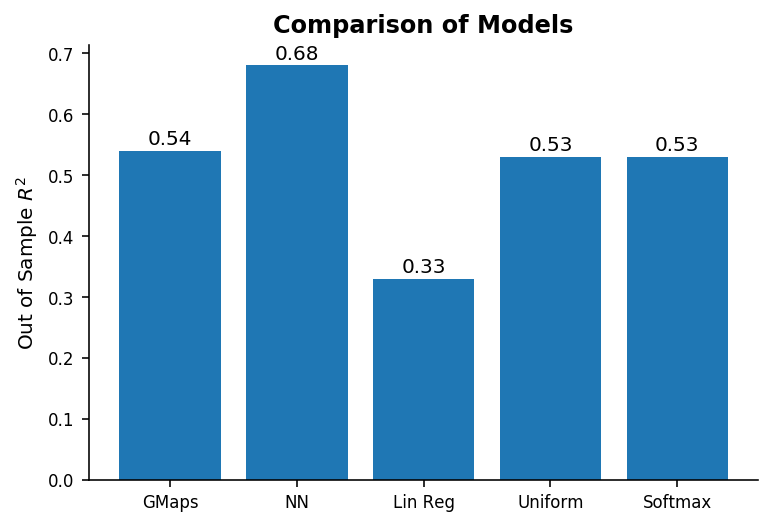

In [25]:
y = np.array([.54, .68, .33, .53, .53])
models = ['GMaps', 'NN', 'Lin Reg', 'Uniform', 'Softmax']
x = np.arange(len(y))


plt.bar(x, y)
plt.xticks(x, models)
for x1, y1 in zip(x,y):
    plt.annotate(str(y1), (x1,y1+.01), ha='center')
sns.despine()

plt.title('Comparison of Models')
plt.ylabel('Out of Sample $R^2$')